<a href="https://colab.research.google.com/github/julie-dfx/causal-decision-analytics/blob/main/00_reboot_01_statistics_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reboot: Statistics from Scratch

## Problem
Refresh core statistical intuition and rebuild confidence in Python
by implementing basic statistical concepts from first principles.

## Assumptions
- Data are generated from known distributions
- Focus is on understanding, not performance
- No black-box libraries are used for core logic

## Method
Use simulations to explore sampling distributions, bias, and variance.
Implement estimators manually.

## Results

- By repeatedly sampling from the same data-generating process, I observed that
  the sampling distribution of the sample mean becomes more concentrated as the
  number of observations increases.
- This illustrates the Law of Large Numbers in practice: although individual
  observations are noisy, the sample mean converges to the true population mean
  as the number of observations grows.
- Increasing sample size reduces the variance of the estimator but does not
  eliminate bias: a deliberately biased estimator remains systematically shifted
  away from the true value even with more data.


- The variance of the sample mean decreases as sample size increases, confirming
  that more data stabilizes the estimator even though individual observations
  remain noisy.
- By resampling the observed data, the bootstrap provides an empirical
  approximation of the sampling distribution of the estimator.
- Bootstrap confidence intervals summarize uncertainty about the estimator given
  the observed data.

- Estimation uncertainty implies that decisions based on data are inherently
  probabilistic rather than deterministic.
- Decision-making requires defining thresholds that reflect risk tolerance and
  the asymmetric cost of different types of errors.
- Statistical outputs such as confidence intervals inform decisions but do not,
  by themselves, determine the optimal action.


## Limitations
- Only Gaussian data-generating process
- Artificially constructed biased estimator
- No real-world confounding yet

- Bootstrap assumes the observed sample is representative of the population.
- The bootstrap approximation may be unreliable for very small samples.
- All experiments rely on simulated data with known distributions.

- The decision problem is highly simplified and assumes a single effect estimate.
- Error costs are discussed qualitatively rather than modeled explicitly.
- No real operational constraints or secondary effects are included.


In [1]:
import random
import math
import matplotlib.pyplot as plt

In [2]:
# Define a data generating process
def generate_sample(n):
    """
    Generate n observations from a standard normal distribution.
    """
    return [random.gauss(0, 1) for n in range(n)]

In [3]:
generate_sample(5)

[-0.614249294351999,
 0.44163655049512074,
 0.07182492985495162,
 -1.0912577659402602,
 2.5795648512295184]

In [4]:
# Define the sample mean manually
def sample_mean(x):
    """
    Compute the sample mean manually
    """
    return sum(x) / len(x)

In [5]:
sample_mean([1, 2, 3, 4])

2.5

In [6]:
# Simulate sampling distribution
def sampling_distribution(n, n_sim=1000):
    """
    Simulate the sampling distribution of the sample mean.
    """
    means=[]
    for i in range (n_sim):
        sample = generate_sample(n)
        mean = sample_mean(sample)
        means.append(sample_mean(sample))
    return means


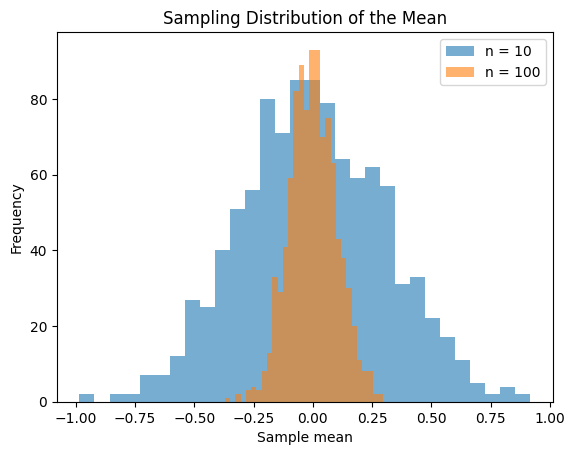

In [7]:
means_small = sampling_distribution(10)
means_large = sampling_distribution(100)

plt.hist(means_small, bins=30, alpha=0.6, label="n = 10")
plt.hist(means_large, bins=30, alpha=0.6, label="n = 100")
plt.legend()
plt.title("Sampling Distribution of the Mean")
plt.xlabel("Sample mean")
plt.ylabel("Frequency")
plt.show()

 simulate repeated samples from a fixed data-generating process and compute the sample mean for each sample. Repeating this many times allows me to observe the sampling distribution of the estimator (the sample mean).

When the sample size increases from n = 10 to n = 100, the sampling distribution of the mean becomes much more concentrated around the true population mean (0). This does not mean that the mean is computed more “accurately” in a numerical sense, but rather that the variance of the estimator decreases as sample size increases.

This illustrates the Law of Large Numbers: although individual observations are noisy, the sample mean converges to the true mean as the number of observations grows.


In [8]:
# Define a deliberately biased estimator of the mean
def biased_mean(x):
    return (sum(x) / len(x)) + 0.5

In [9]:
def evaluate_estimators(n, n_sim=1000):
    true_value = 0
    unbiased_estimates = []
    biased_estimates = []

    for _ in range(n_sim):
        sample = generate_sample(n)
        unbiased_estimates.append(sample_mean(sample))
        biased_estimates.append(biased_mean(sample))

    return unbiased_estimates, biased_estimates


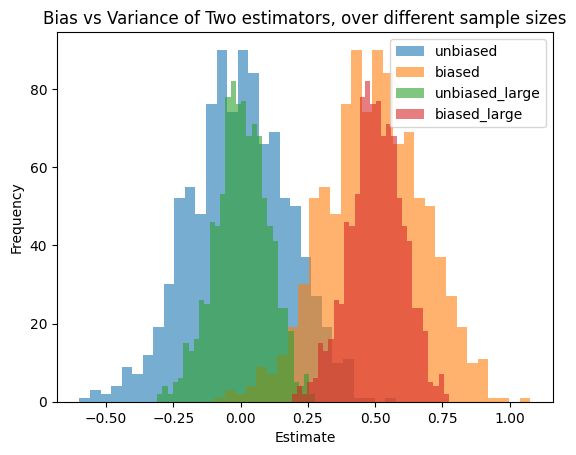

In [10]:
#viz

unbiased, biased = evaluate_estimators(n=30)
unbiased_large, biased_large = evaluate_estimators(n=100)


plt.hist(unbiased, bins=30, alpha = 0.6, label="unbiased")
plt.hist(biased, bins=30, alpha=0.6, label="biased")
plt.hist(unbiased_large, bins=30, alpha = 0.6, label="unbiased_large")
plt.hist(biased_large, bins=30, alpha=0.6, label="biased_large")
plt.legend()
plt.title("Bias vs Variance of Two estimators, over different sample sizes")
plt.xlabel("Estimate")
plt.ylabel("Frequency")
plt.show()

In [11]:
#Define variance manually

def sample_variance(x):
    """
    Compute the sample variance manually
    """
    mean_x = sample_mean(x)
    squared_diffs = [(xi-mean_x) **2 for xi in x]
    return sum(squared_diffs) / len(x)

In [12]:
sample_variance([1, 2, 3, 4])

1.25

In [13]:
#Variance accross repeated samples
def variance_of_estimator(n, n_sim=1000):
    estimates = []
    for _ in range(n_sim):
        sample = generate_sample(n)
        estimates.append(sample_mean(sample)) #our estimator is still the mean
    return sample_variance(estimates)

In [14]:
variance_of_estimator(10), variance_of_estimator(100) # as the number of obervation grows, variance reduces

(0.10380351943634132, 0.009894715700862552)

By repeatedly samply data and computing the sample mean, I can treat the estimates themselves as a dataset. Computing the variance of these estimates quantifies how much the estimator fluctuates across repeated samples.

As sample size increases, the variance of the sample mean decreases, confirming that more data stabilizes the estimator.



In [15]:
#implement bootstrap resampling
def bootstrap_sample(x):
    """
    Draw a bootstrap sample (same size, sampled with replacement
    """
    return [random.choice(x) for _ in range(len(x))] #resampling from the orgiinal dataset


In [16]:
#Bootstrap the sample mean
def bootstrap_means(x, n_bootstrap=1000): # we resample 1000 times
    means = []
    for _ in range(n_bootstrap):
        sample = bootstrap_sample(x)
        means.append(sample_mean(sample))
    return means # That list is the bootstrap approximation of the sampling distribution

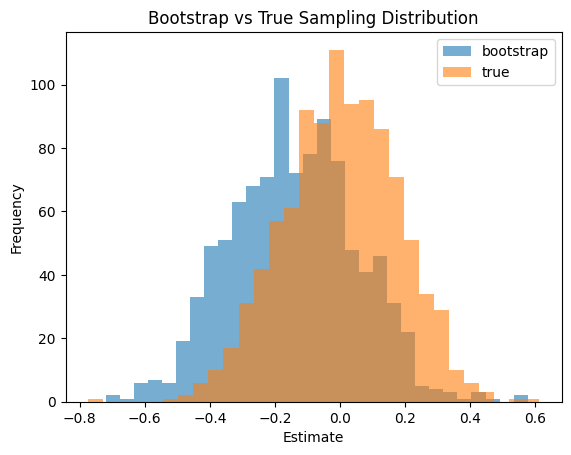

In [17]:
#Compare bootstrap vs true sampling distribution
original_sample = generate_sample(30)

bootstrap_estimates = bootstrap_means(original_sample)
true_estimates = sampling_distribution(30)

plt.hist(bootstrap_estimates, bins = 30, alpha=0.6, label="bootstrap")
plt.hist(true_estimates, bins = 30, alpha=0.6, label="true")
plt.legend()
plt.title("Bootstrap vs True Sampling Distribution")
plt.xlabel("Estimate")
plt.ylabel("Frequency")
plt.show()

In [18]:
#implement Confidence intervals (CI) manually
def bootstrap_ci(bootstrap_estimates, alpha=0.05): # 1-alpha is the confidence level (eg 95%)
    lower = sorted(bootstrap_estimates[int(alpha/2)*len(bootstrap_estimates)])
    upper = sorted(bootstrap_estimates[int(1-alpha/2)*len(bootstrap_estimates)])
    return lower, upper



In [20]:
#bootstrap_ci(bootstrap_estimates) #issue with float

## From estimation to decision-making

So far, I focused on estimating quantities and understanding uncertainty.
In practice, estimates are used to make decisions under uncertainty, where
different errors have different costs.

Statistical outputs should therefore be interpreted in the context of decisions,
not as binary accept/reject tests.

### Decision problem

Assume I am deciding whether a change improves an outcome.
- If the true effect is positive, I want to act.
- If the true effect is negative or zero, I do not want to act.

My estimate is uncertain, so I must decide based on an estimate and its
uncertainty rather than the true effect.


In [22]:
#Simulate an estimated effect
def simulate_estimated_effect(true_effect, n=30, noise_std=1.0):
    """
    Simulate an estimated effect as the true effect + sime noise
    """
    noise = random.gauss(0, noise_std / math.sqrt(n))
    return true_effect + noise

In [23]:
def simulate_estimates(true_effect, n_sim=1000):
    return [simulate_estimated_effect(true_effect) for _ in range(n_sim)]

In [24]:
estimates = simulate_estimates(true_effect=0.2)

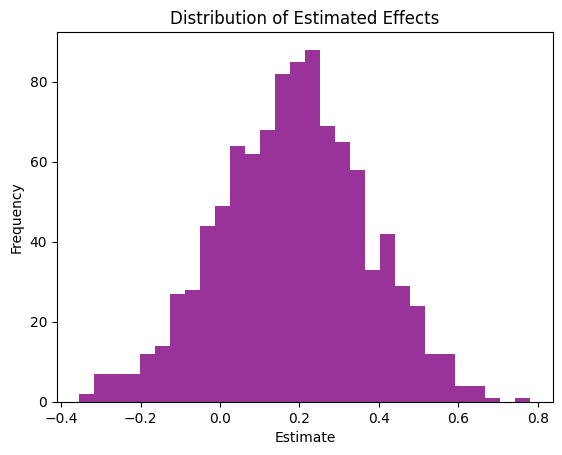

In [29]:
#visualise uncertainty
plt.hist(estimates, bins=30, alpha=0.8, color='purple')
plt.title("Distribution of Estimated Effects")
plt.xlabel("Estimate")
plt.ylabel("Frequency")
plt.show()

we only want to act if the effect is positive, but some estimates are negative
reality is uncertain, even if the true effect is positive

#Decisions are thresholds not tests

###A simple decision rule is:
- Act if the estimated esffect is above a chosen threshold
- Do not act otherwise

The threshol reflects risk tolerance and the relative cost of mistakes

In [30]:
#Simulate decisions under uncertainty
def decision_outcomes(estimates, threshold=0):
    decisions = []
    for est in estimates:
        decisions.append(est > threshold) #True, False
    return decisions

In [36]:
decisions = decision_outcomes(estimates, threshold=0)
sum(decisions) / len(decisions) #fraction of times we would act (%)


0.833

###Interpretation

Even when the true underlying effect is positive, estimation uncertainty can cause some estimated effects to fall below zero. As a result, any binary decision rule based on a fixed threshold will inevitably produce both false negatives (failing to act when the effect is truly positive) and false positives (acting when the effect is not truly positive).

Therefore, selecting a decision threshold is not purely a statistical exercise. It requires weighing the cost of acting unnecessarily against the cost of missing a genuinely beneficial effect. The appropriate threshold depends on these relative costs and the decision context, not just on statistical significance alone.

### Why statistical significance is insufficient

A statistically significant result does not automatically imply a good decision,
and a non-significant result does not automatically imply inaction.

Decisions should be based on estimated effect sizes, uncertainty, and the costs
of different types of errors, rather than on arbitrary significance thresholds.
